#2018111034

In [1]:
!pip install gif

     |████████████████████████████████| 2.2MB 2.5MB/s 
  Created wheel for gif: filename=gif-3.0.0-cp36-none-any.whl size=4816 sha256=ea1ecc0e22ad8d5119aac78b2049f683dc5cfc3e1987027015364ba14b854808
  Stored in directory: /root/.cache/pip/wheels/33/1a/03/e7ccc13d5cbed82b0fda53a7792dfe372cf8baf691601d78d1
Successfully built gif
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


# Logistic Regression Excercise 2

## Multi-class classification of MNIST using Logistic Regression

The multi-class scenario for logistic regression is quite similar to the binary case, except that the label $y$ is now an integer in {1, ...., K} where $K$ is the number of classes. In this excercise you will be provided with handwritten digit images. Write the code and compute the test accuracy by training a logistic regression based classifier in (i) one-vs-one, and (ii) one-vs-all setting.

In [2]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        #print('searching: %s'%nb_path)
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        #print('searching: %s' % nb_path)
        if os.path.isfile(nb_path):
            return nb_path

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        #print('Found %d cells'%len(nb.cells))
        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]


#  register the NotebookFinder with sys.meta_path
print('running importer')
sys.meta_path.append(NotebookFinder())

running importer


In [3]:
from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set();
import pandas as pd
from utils import plot_decision_boundary, get_accuracy, get_prediction
from utils import plot_2D_input_datapoints, generate_gifs, sigmoid, normalize
import math
import gif
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

importing Jupyter notebook from utils.ipynb


In [4]:
# Let's initialize our weights using uniform distribution
def weight_init_uniform_dist(X, y):
  
    np.random.seed(312)
    n_samples, n_features = np.shape(X)
    _, n_outputs = np.shape(y)

    limit = 1 / math.sqrt(n_features)
    weights = np.random.uniform(-limit, limit, (n_features, n_outputs))
    weights[-1] = 0

    return weights

In [5]:
np.random.seed(12)

# One hot encoding of our output label vector y
def one_hot(a):
    b = np.zeros((a.size, a.max()+1))
    b[np.arange(a.size), a] = 1
    return b

# Loading dataset
digits = datasets.load_digits()

# One-hot encoding of target label, Y
Y = digits.target
Y = one_hot(Y)

# Absorbing weight b of the hyperplane
X = digits.data
b_ones = np.ones((len(X), 1))
X = np.hstack((X, b_ones))

<Figure size 432x288 with 0 Axes>

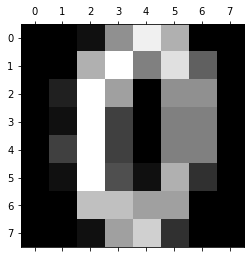

In [6]:
sns.reset_orig()

plt.gray()
plt.matshow(digits.images[10])
plt.show();

In [7]:
# Splitting dataset into train, val, and test set.
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, shuffle=True, test_size = 0.167)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = 0.12517)

print("Training dataset: ", X_train.shape)
print("Validation dataset: ", X_val.shape)
print("Test dataset: ", X_test.shape)

Training dataset:  (1308, 65)
Validation dataset:  (188, 65)
Test dataset:  (301, 65)


In [8]:
# Normalizing X_train and absorbing weight b of the hyperplane
X_normalized_train = normalize(X_train[:, :64])

b_ones = np.ones((len(X_normalized_train), 1))
X_normalized_train = np.hstack((X_normalized_train, b_ones))

In [9]:
X_normalized_train.shape

(1308, 65)

### Write your code below

In [18]:

def train(X, Y, epochs=1000, lr=0.01):
    n_samples, n_features = X.shape
    const = 1 / np.sqrt(n_features)
    W = np.random.randn(n_features, 1) * const
    W[-1, :] = 0
    for epoch in range(epochs):
        Y_pred = sigmoid(np.dot(X , W))
        gradient = np.dot(1 / n_samples * X.T , (Y - Y_pred))
        W += lr * gradient
        if epoch % (epochs // 5) == 0:
            Y_pred = np.where(Y == 1, Y_pred, 1 - Y_pred)
            cost = -1 / Y.shape[0] * np.sum(np.log(Y_pred))
            print(f"Epoch {epoch}: train loss {cost}")
    return W


#OneVSOne

In [19]:
def onevsoneClassifier(X_train, Y_train, epochs=1000, lr=0.01):
    n_examples, n_features = X_train.shape
    _, n_classes = Y_train.shape
    
    W = []
    print(f"Training one vs one classifier starts")
    for k1 in range(n_classes):
        for k2 in range(n_classes):
            print(f"Training {k1} vs {k2} classifier")
            idx = np.where((Y_train[:, k1] == 1) | (Y_train[:, k2] == 1))
            X = X_train[idx]
            Y = Y_train[:, k1:k1+1][idx]
            W.append(train(X, Y, epochs, lr).ravel())
    print(f"Training one vs one classifier ends")
    return np.array(W).T
    
W_onevsone = onevsoneClassifier(X_normalized_train, Y_train)
W_onevsone.shape

Training one vs one classifier starts
Training 0 vs 0 classifier
Epoch 0: train loss 0.6805310212344258
Epoch 200: train loss 0.24627001934011258
Epoch 400: train loss 0.13817201211629918
Epoch 600: train loss 0.0940471988150826
Epoch 800: train loss 0.07074130268291665
Training 0 vs 1 classifier
Epoch 0: train loss 0.6781493690660565
Epoch 200: train loss 0.6234937178280189
Epoch 400: train loss 0.5755938537514068
Epoch 600: train loss 0.5334333709736282
Epoch 800: train loss 0.4962110542512024
Training 0 vs 2 classifier
Epoch 0: train loss 0.6789081865078516
Epoch 200: train loss 0.6309898757682858
Epoch 400: train loss 0.5896396871034589
Epoch 600: train loss 0.5527177938631298
Epoch 800: train loss 0.5194816177003921
Training 0 vs 3 classifier
Epoch 0: train loss 0.7077230312620243
Epoch 200: train loss 0.6621161181558741
Epoch 400: train loss 0.6208335565079475
Epoch 600: train loss 0.5833547802211768
Epoch 800: train loss 0.5492830615318092
Training 0 vs 4 classifier
Epoch 0: tra

(65, 100)

In [20]:
def accuracy_onevsone(X, Y, W):
    n_classes = int(np.sqrt(W.shape[1]))
    y_pred = np.argmax(np.dot(X , W), axis = 1) // n_classes
    return np.sum(Y[np.arange(Y.shape[0]), y_pred]) / Y.shape[0]

print(f"Training accuracy: {accuracy_onevsone(X_train, Y_train, W_onevsone)}")
print(f"Validation accuracy: {accuracy_onevsone(X_val, Y_val, W_onevsone)}")
print(f"Test accuracy: {accuracy_onevsone(X_test, Y_test, W_onevsone)}")

Training accuracy: 0.7362385321100917
Validation accuracy: 0.75
Test accuracy: 0.7541528239202658


#OneVSAll

In [13]:
def onevsallClassifier(X_train, Y_train, epochs=1000, lr=0.01):
    n_examples, n_features = X_train.shape
    _, n_classes = Y_train.shape
    
    W = []
    print(f"Training one vs all classifier starts")
    for k in range(n_classes):
        print(f"{k} vs all classifier starts")
        W.append(train(X_train, Y_train[:,k:k+1], epochs, lr).ravel())
        print(f"{k} vs all classifier ends")
    print(f"Training one vs all classifier ends")
    return np.array(W).T

W_onevsall = onevsallClassifier(X_train, Y_train)

Training one vs all classifier starts
0 vs all classifier starts
Epoch 0: train loss 1.664570350040058
Epoch 200: train loss 0.012751109634733127
Epoch 400: train loss 0.007167189652143115
Epoch 600: train loss 0.0051393683801813205
Epoch 800: train loss 0.00408826344654866
0 vs all classifier ends
1 vs all classifier starts
Epoch 0: train loss 2.29764698407135
Epoch 200: train loss 0.067179540840804
Epoch 400: train loss 0.056895696498393725
Epoch 600: train loss 0.0518750097213722
Epoch 800: train loss 0.04867523220692286
1 vs all classifier ends
2 vs all classifier starts
Epoch 0: train loss 2.6251460999090894
Epoch 200: train loss 0.027874662914575188
Epoch 400: train loss 0.016604970123899724
Epoch 600: train loss 0.012075848336271124
Epoch 800: train loss 0.009582452444725926
2 vs all classifier ends
3 vs all classifier starts
Epoch 0: train loss 1.3264571479382945
Epoch 200: train loss 0.056984945827675076
Epoch 400: train loss 0.04158352931328251
Epoch 600: train loss 0.0351346

In [14]:

def accuracy_onevsall(X, Y, W):
    y_pred = np.argmax(np.dot(X , W), axis = 1)
    return np.sum(Y[np.arange(Y.shape[0]), y_pred]) / Y.shape[0]

print(f"Training accuracy: {accuracy_onevsall(X_train, Y_train, W_onevsall)}")
print(f"Validation accuracy: {accuracy_onevsall(X_val, Y_val, W_onevsall)}")
print(f"Test accuracy: {accuracy_onevsall(X_test, Y_test, W_onevsall)}")

Training accuracy: 0.981651376146789
Validation accuracy: 0.9521276595744681
Test accuracy: 0.9568106312292359
